In [12]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [13]:
def parse_data_file(filename):
    # Чтение файла и парсинг данных по каналам без сохранения во временные csv
    with open(filename, "r") as raw_data:
        channel_data = {}
        headers = {}
        channel_order = []
        while True:
            line = raw_data.readline()
            if not line:
                break
            if line.startswith("#CHANNEL"):
                ch = line.split(":")[1].strip()
                channel_order.append(ch)
                size_line = raw_data.readline()
                size = int(size_line.strip().split('=')[1])
                header_line = raw_data.readline().strip().split(",")
                headers[ch] = header_line
                channel_data[ch] = []
                for i in range(size):
                    data_line = raw_data.readline().strip().split(",")
                    channel_data[ch].append(data_line)
    # Преобразуем данные каналов в DataFrame
    dfs = {}
    for ch in channel_order:
        dfs[ch] = pd.DataFrame(channel_data[ch], columns=headers[ch])
        for col in dfs[ch].columns:
            dfs[ch][col] = pd.to_numeric(dfs[ch][col], errors='coerce')
    # Собираем итоговый DataFrame
    data = pd.DataFrame()
    # Предполагаем, что первый канал содержит время
    time_col = None
    for col in dfs[channel_order[0]].columns:
        if "Time" in col:
            time_col = col
            break
    if time_col is None:
        raise ValueError("Не найден столбец времени в первом канале")
    data["Time, s"] = dfs[channel_order[0]][time_col]
    # Добавляем все каналы
    for idx, ch in enumerate(channel_order):
        volt_col = None
        for col in dfs[ch].columns:
            if "Volt" in col:
                volt_col = col
                break
        if volt_col is not None:
            data[f"V_{idx+1}"] = dfs[ch][volt_col]
    return data


In [14]:
data = parse_data_file("data_new_final_tochno_tochno_5.txt")
data

,"Time, s",V_1,V_2,V_3
0,0.000000,0.138,3.68,3.20
1,0.000008,0.138,3.72,3.20
2,0.000016,0.138,3.72,3.20
3,0.000024,0.138,3.68,3.20
4,0.000032,0.140,3.64,3.20
...,...,...,...,...
3995,0.031960,0.184,4.60,-0.56
3996,0.031968,0.186,4.56,-0.48
3997,0.031976,0.188,4.56,-0.48
3998,0.031984,0.184,4.56,-0.48


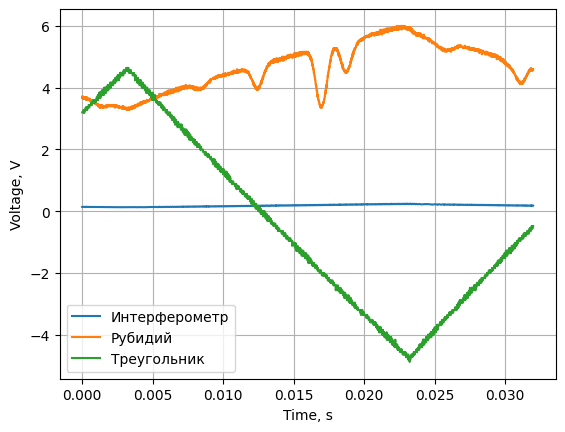

In [15]:

plt.plot(data["Time, s"], data["V_1"], label="Интерферометр")
plt.plot(data["Time, s"], data["V_2"], label="Рубидий")
plt.plot(data["Time, s"], data["V_3"], label="Треугольник")
plt.xlabel("Time, s")
plt.ylabel("Voltage, V")
plt.legend()
plt.grid()



74.9481145 MHz
154 
 [1.44 1.44 1.36 1.44 1.28]


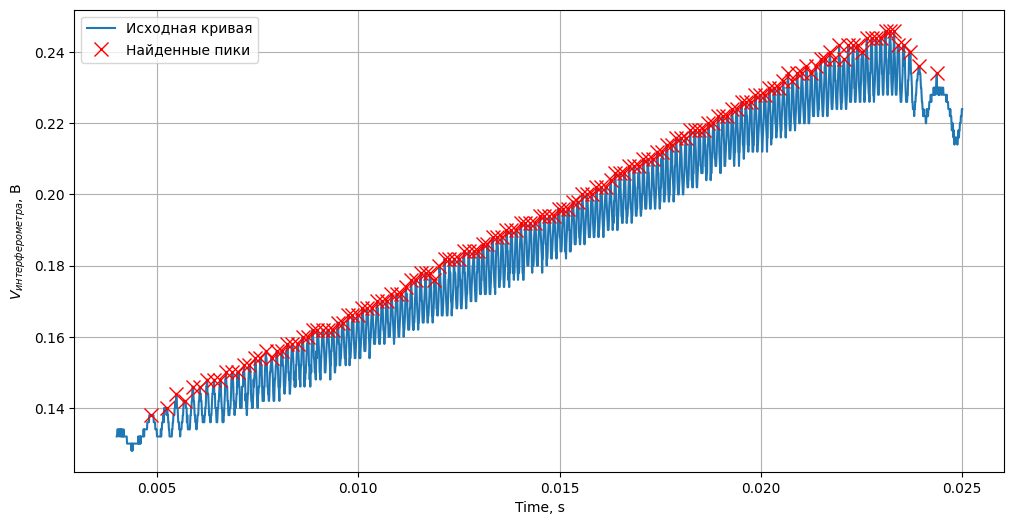

C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12860\1521619858.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)


In [16]:
c = 299792458
a = 1
dnu = c/(4*a)
print(dnu*1E-6, 'MHz') # частоты между пиками интерферометра

# Допустим, у нас есть массив y с значениями кривой
cut_data_wide = data[(data["Time, s"] >= 0.0040) & (data["Time, s"] <= 0.025)]
cut_data = data[(data["Time, s"] >= 0.0055) & (data["Time, s"] <= 0.0235)]
x=cut_data_wide["Time, s"]
y=cut_data_wide["V_1"]
# Находим пики (локальные максимумы)
peaks, _ = sp.signal.find_peaks(np.array(y),   
    distance=10 ,          # минимум 50 точек между пиками
    prominence=0.005,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(len(distances),"\n",distances[10:15]*10000)
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("$V_{интерферометра}$, В")
plt.grid(True)
plt.show()

def delta_nu(t):
    i = len(peaksx[peaksx<t])-1
    if i < 0 or i >= len(peaksx) - 1:
        raise ValueError("t вне диапазона пиков интерферометра")
    return dnu*(i + (t-peaksx[i])/(peaksx[i+1]-peaksx[i])) 

cut_data["nu"] = cut_data["Time, s"].apply(delta_nu)



<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12860\39059975.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta \\nu$, Гц")


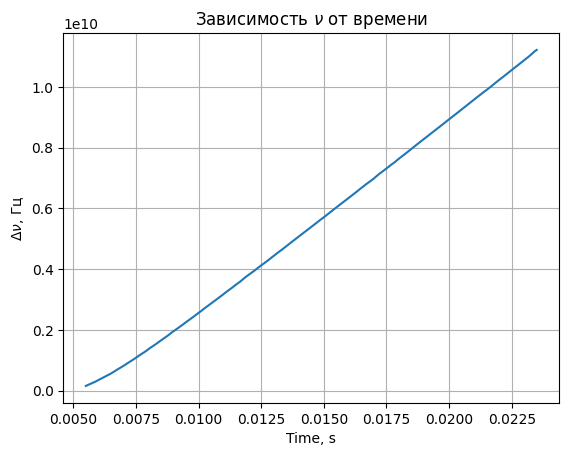

In [17]:
plt.plot(cut_data["Time, s"], cut_data["nu"])
plt.xlabel("Time, s")
plt.ylabel("$\Delta \\nu$, Гц")
plt.title("Зависимость $\\nu$ от времени")
plt.grid(True)
plt.show()


C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12860\3038531698.py:46: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)


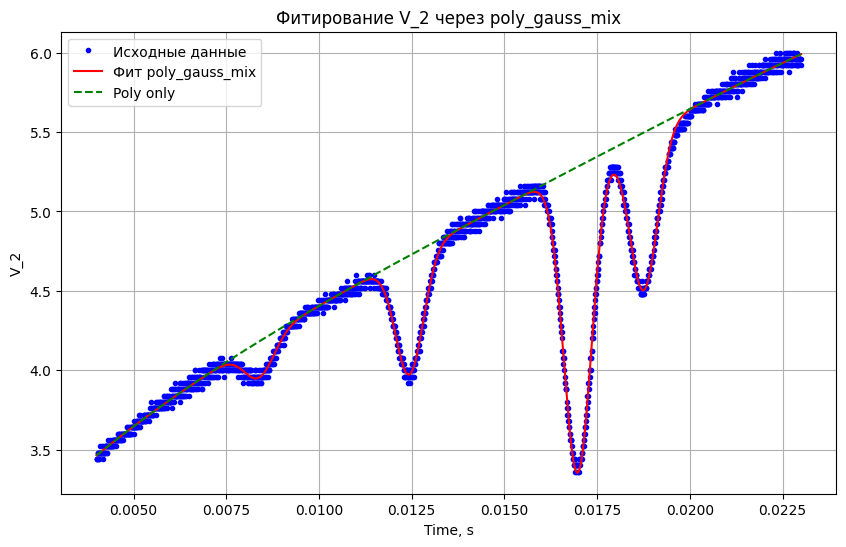

p[0] = 0.0
p[1] = 0.0
p[2] = 0.0
p[3] = 0.0
p[4] = 295.5443151000816
p[5] = -101.22825990698948
p[6] = -7476282.829025008
p[7] = 497971.04778673034
p[8] = -12736.399177488014
p[9] = 269.70732250997156
p[10] = 2.5584922017424385
p[11] = 0.05435043454770206
p[12] = 0.008390933366347697
p[13] = 0.0003985822350950927
p[14] = 0.15856666339705922
p[15] = 0.012438041591477404
p[16] = 0.00037437399820370443
p[17] = 0.3648395490041365
p[18] = 0.016973342931223483
p[19] = 0.0003764042273430991
p[20] = 0.1804887196299096
p[21] = 0.018755742967511164
p[22] = 0.00037731075459140185
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  2.95544315e+02 -1.01228260e+02 -7.47628283e+06  4.97971048e+05
 -1.27363992e+04  2.69707323e+02  2.55849220e+00] [0.05435043 0.00839093 0.00039858 0.15856666 0.01243804 0.00037437
 0.36483955 0.01697334 0.0003764  0.18048872 0.01875574 0.00037731]


In [18]:
cut_data_wide = data[(data["Time, s"] >= 0.004) & (data["Time, s"] <= 0.023)]

def poly_gauss_mix(x, *params):
    """
    params: [p0, p1, ..., pn, A1, mu1, sigma1, ..., A4, mu4, sigma4]
    p0...pn — коэффициенты многочлена степени n
    Ai, mui, sigmai — параметры 4 гауссиан
    """
    n = 4  # число гауссиан
    poly_deg = len(params) - n*3
    poly_coeffs = params[:poly_deg]
    gauss_params = params[poly_deg:]
    # Многочлен
    poly = np.polyval(poly_coeffs, x)
    # Сумма 4 гауссиан
    gauss_sum = 0
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return poly * (1-gauss_sum)



gauss_params = [0.1, 0.008, 0.0004,  # First Gaussian
                0.1, 0.0125, 0.0004,
                0.1,0.0170,0.0004,
                0.1,0.018,0.0004]  # Second Gaussian

x = cut_data_wide["Time, s"].values
y = cut_data_wide["V_2"].values

# Fit V_2 with a polynomial of degree 3
poly_params = np.polyfit(x, y, 1)
# Update initial_params with the fitted polynomial coefficients
initial_params = list(poly_params) + gauss_params

# Графики
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b.', label='Исходные данные')
# Фитирование
popt_1, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
degree = 10
initial_params = [0]*(degree-1) + list(popt_1) # Добавляем степени многочлена
popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
poly_params = popt_2[:degree+1]
gauss_params = popt_2[degree+1:]
# Графики
plt.plot(x, poly_gauss_mix(x, *popt_2), 'r-', label='Фит poly_gauss_mix')
plt.xlabel("Time, s")
plt.ylabel("V_2")
plt.legend()
plt.grid(True)
plt.title("Фитирование V_2 через poly_gauss_mix")
plt.plot(x, np.polyval(poly_params, x), 'g--', label='Poly only')
plt.legend()
plt.show()
for i, coef in enumerate(popt_2):
    print(f"p[{i}] = {coef}")
gauss_params_times = gauss_params
print(poly_params, gauss_params)

<>:52: SyntaxWarning: invalid escape sequence '\D'
<>:52: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12860\2220612888.py:52: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \\nu$, МГц")


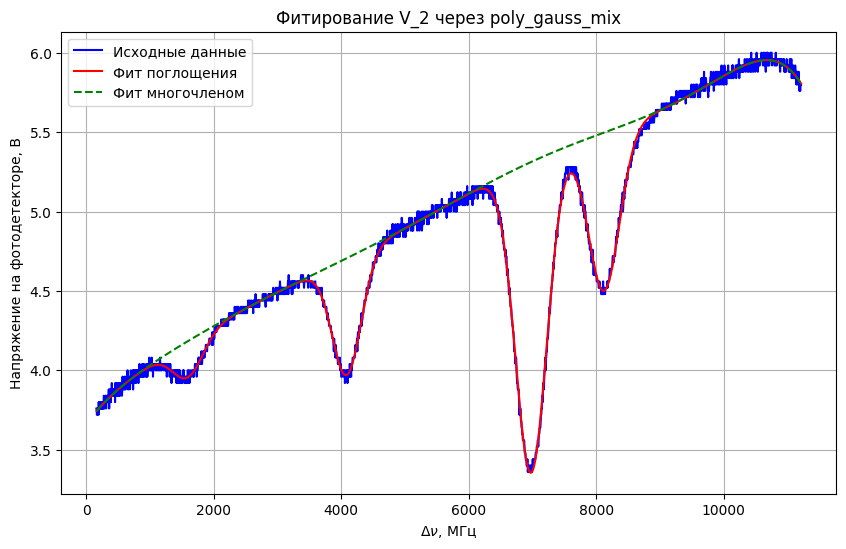

p[0] = -1.8581926704937597e-78
p[1] = 7.496783020581281e-68
p[2] = -1.2240616761369758e-57
p[3] = 1.0460211352190258e-47
p[4] = -5.103854690669241e-38
p[5] = 1.4868522747595778e-28
p[6] = -2.725435114120557e-19
p[7] = 5.323921130379748e-10
p[8] = 3.6660270603029037
p[9] = 0.05441738487718883
p[10] = 1591304298.9225118
p[11] = 236583795.83128124
p[12] = 0.15614143799320002
p[13] = 4083512462.2915936
p[14] = 227786686.40596065
p[15] = 0.36828384416945337
p[16] = 6977613825.5583105
p[17] = 245720586.35351577
p[18] = 0.18117279060849048
p[19] = 8122844734.441465
p[20] = 243164031.85150555
[-1.85819267e-78  7.49678302e-68 -1.22406168e-57  1.04602114e-47
 -5.10385469e-38  1.48685227e-28 -2.72543511e-19  5.32392113e-10
  3.66602706e+00] [5.44173849e-02 1.59130430e+09 2.36583796e+08 1.56141438e-01
 4.08351246e+09 2.27786686e+08 3.68283844e-01 6.97761383e+09
 2.45720586e+08 1.81172791e-01 8.12284473e+09 2.43164032e+08]


In [19]:
cut_data

def poly_gauss_mix(x, *params):
    """
    params: [p0, p1, ..., pn, A1, mu1, sigma1, ..., A4, mu4, sigma4]
    p0...pn — коэффициенты многочлена степени n
    Ai, mui, sigmai — параметры 4 гауссиан
    """
    n = 4  # число гауссиан
    poly_deg = len(params) - n*3
    poly_coeffs = params[:poly_deg]
    gauss_params = params[poly_deg:]
    # Многочлен
    poly = np.polyval(poly_coeffs, x)
    # Сумма 4 гауссиан
    gauss_sum = 0
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        gauss_sum += A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return poly * (1-gauss_sum)



gauss_params = [0.1, 0.18e10, 200e6,  # First Gaussian
                0.1, 0.40e10, 200e6,
                0.1,0.7e10,200e6,
                0.1,0.81e10,200e6]  # Second Gaussian

x = cut_data["nu"].values
y = cut_data["V_2"].values

# Fit V_2 with a polynomial of degree 3
poly_params = np.polyfit(x, y, 1)
# Update initial_params with the fitted polynomial coefficients
initial_params = list(poly_params) + gauss_params

plt.figure(figsize=(10, 6))
plt.plot(x/10**6, y, 'b-', label='Исходные данные')

# Фитирование
popt_1, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
degree = 8
initial_params = [0]*(degree-1) + list(popt_1) # Добавляем степени многочлена
popt_2, pcov = sp.optimize.curve_fit(poly_gauss_mix, x, y, p0=initial_params, maxfev=5000)
poly_params = popt_2[:degree+1]
gauss_params = popt_2[degree+1:]
# Графики

plt.plot(x/10**6, poly_gauss_mix(x, *popt_2), 'r-', label='Фит поглощения')
plt.xlabel("$\Delta \\nu$, МГц")
plt.ylabel("Напряжение на фотодетекторе, В")
plt.legend()
plt.grid(True)
plt.title("Фитирование V_2 через poly_gauss_mix")
plt.plot(x/10**6, np.polyval(poly_params, x), 'g--', label='Фит многочленом')
plt.legend()
plt.show()
for i, coef in enumerate(popt_2):
    print(f"p[{i}] = {coef}")

print(poly_params, gauss_params)

<>:23: SyntaxWarning: invalid escape sequence '\D'
<>:23: SyntaxWarning: invalid escape sequence '\D'
C:\Users\RedBrean\AppData\Local\Temp\ipykernel_12860\2906765109.py:23: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel("$\Delta \\nu$, МГц")


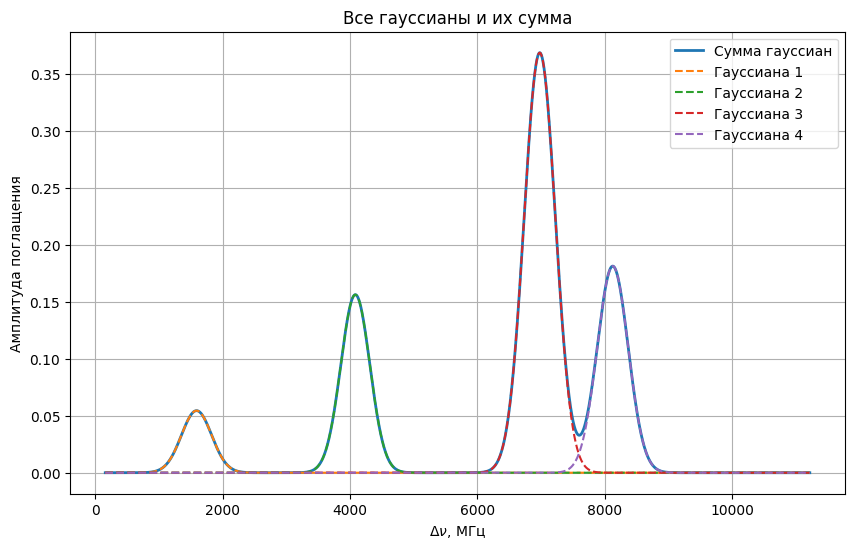

In [20]:
def sum_gaussians(x, gauss_params):
    n = len(gauss_params) // 3
    gauss_sum = np.zeros_like(x, dtype=float)
    gaussians = []
    for i in range(n):
        A = gauss_params[i*3]
        mu = gauss_params[i*3+1]
        sigma = gauss_params[i*3+2]
        g = A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
        gauss_sum += g
        gaussians.append(g)
        
    return gauss_sum, gaussians

gauss_params_tuples = [(gauss_params[i*3], gauss_params[i*3+1], gauss_params[i*3+2]) for i in range(len(gauss_params)//3)]
gauss_params_tuples_time = [(gauss_params_times[i*3], gauss_params_times[i*3+1], gauss_params_times[i*3+2]) for i in range(len(gauss_params_times)//3)]

plt.figure(figsize=(10, 6))
total, gaussians = sum_gaussians(x, gauss_params)
plt.plot(x/10**6, total, label="Сумма гауссиан", linewidth=2)
for i, g in enumerate(gaussians):
    plt.plot(x/10**6, g, '--', label=f'Гауссиана {i+1}')
plt.xlabel("$\Delta \\nu$, МГц")
plt.ylabel("Амплитуда поглащения")
plt.title("Все гауссианы и их сумма")
plt.grid(True)
plt.legend()
plt.show()


In [21]:
add_nu_all = np.array([[194,-72,-230],[100,-20,-84],[-20,-84,-113],[-72,-74,-302]])
weights = np.array([[14/6,5/6,1/6],[81/27,35/27,10/27],[28/27,35/27,1],[5/6,5/6,2/6]])
add_nu_weighted = np.array([np.dot(add_nu_all[i],weights[i])/np.dot(weights[i],weights[i])**(0.5) for i in [0,1,2,3]])
nus_true = np.array([-2563,-1265,1770,4271])
nus_true_w = np.round(nus_true)# + add_nu_weighted,0)
print(nus_true_w[1]-nus_true_w[0],nus_true_w[2]-nus_true_w[1],nus_true_w[3]-nus_true_w[2],"MHz"," - таблица до весов")
nus_true_w = np.round(nus_true + add_nu_weighted,0)
print(nus_true_w[1]-nus_true_w[0],nus_true_w[2]-nus_true_w[1],nus_true_w[3]-nus_true_w[2],"MHz"," - таблица после весов")
print((gauss_params_tuples[1][1]-gauss_params_tuples[0][1])*1E-6,
      (gauss_params_tuples[2][1]-gauss_params_tuples[1][1])*1E-6,
      (gauss_params_tuples[3][1]-gauss_params_tuples[2][1])*1E-6,
      (gauss_params_tuples[3][1]-gauss_params_tuples[0][1])*1E-6, 'MHz'," - мы")
print((delta_nu(gauss_params_tuples_time[1][1])-delta_nu(gauss_params_tuples_time[0][1]))*1E-6,
      (delta_nu(gauss_params_tuples_time[2][1])-delta_nu(gauss_params_tuples_time[1][1]))*1E-6,
      (delta_nu(gauss_params_tuples_time[3][1])-delta_nu(gauss_params_tuples_time[2][1]))*1E-6, 'MHz'," - мы, но линейку позже приложили")
for i, (A, mu, sigma) in enumerate(gauss_params_tuples, 1):
      print(f"Пик поглащения {i}:")
      print(f"  Амплитуда (A): {A:.4g}")
      print(f"  Центр (mu): {mu/1e6:.2f} МГц")
      print(f"  Ширина (sigma): {sigma/1e6:.2f} МГц")
      print(f"  Доплеровское уширинеие (sigma): {2.355*sigma/1e6:.2f} МГц\n")


print(As_experiment)

1298 3035 2501 MHz  - таблица до весов
1229.0 2836.0 2444.0 MHz  - таблица после весов
2492.2081633690814 2894.101363266717 1145.2309088831548 6531.540435518953 MHz  - мы
2494.989907366332 2882.671497139362 1163.091039758852 MHz  - мы, но линейку позже приложили
Пик поглащения 1:
  Амплитуда (A): 0.05442
  Центр (mu): 1591.30 МГц
  Ширина (sigma): 236.58 МГц
  Доплеровское уширинеие (sigma): 557.15 МГц

Пик поглащения 2:
  Амплитуда (A): 0.1561
  Центр (mu): 4083.51 МГц
  Ширина (sigma): 227.79 МГц
  Доплеровское уширинеие (sigma): 536.44 МГц

Пик поглащения 3:
  Амплитуда (A): 0.3683
  Центр (mu): 6977.61 МГц
  Ширина (sigma): 245.72 МГц
  Доплеровское уширинеие (sigma): 578.67 МГц

Пик поглащения 4:
  Амплитуда (A): 0.1812
  Центр (mu): 8122.84 МГц
  Ширина (sigma): 243.16 МГц
  Доплеровское уширинеие (sigma): 572.65 МГц



NameError: name 'As_experiment' is not defined

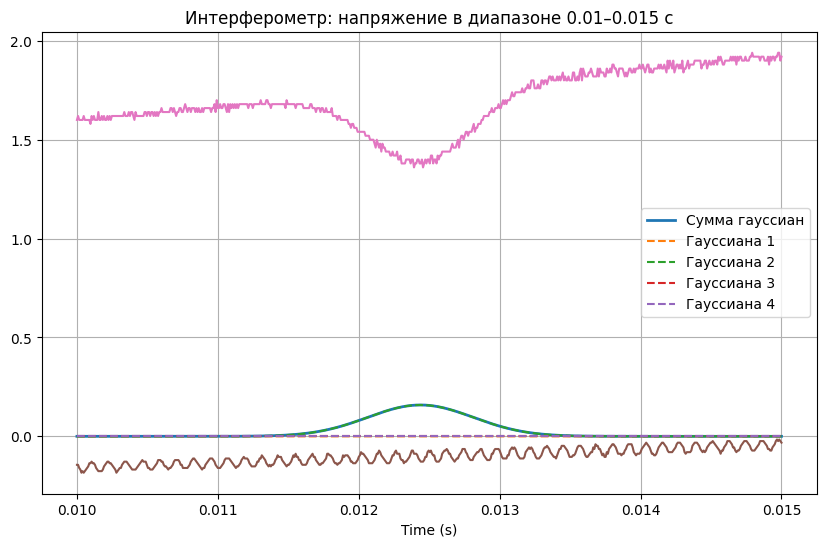

In [ ]:

cut_data_miss = data[(data["Time, s"] >= 0.01) & (data["Time, s"] <= 0.015)]

x = cut_data_miss["Time, s"]
plt.figure(figsize=(10, 6))
total, gaussians = sum_gaussians(x, gauss_params_times)
plt.plot(x, total, label="Сумма гауссиан", linewidth=2)
for i, g in enumerate(gaussians):
    plt.plot(x, g, '--', label=f'Гауссиана {i+1}')
plt.title("Гауссианы и линейка")

plt.plot(cut_data_miss["Time, s"], (cut_data_miss["V_1"]-0.2)*4)
plt.plot(cut_data_miss["Time, s"], (cut_data_miss["V_2"]-1.2)/2)
plt.xlabel("Time (s)")
plt.title("Интерферометр: напряжение в диапазоне 0.01–0.015 с")
plt.grid(True)
plt.legend()
plt.show()


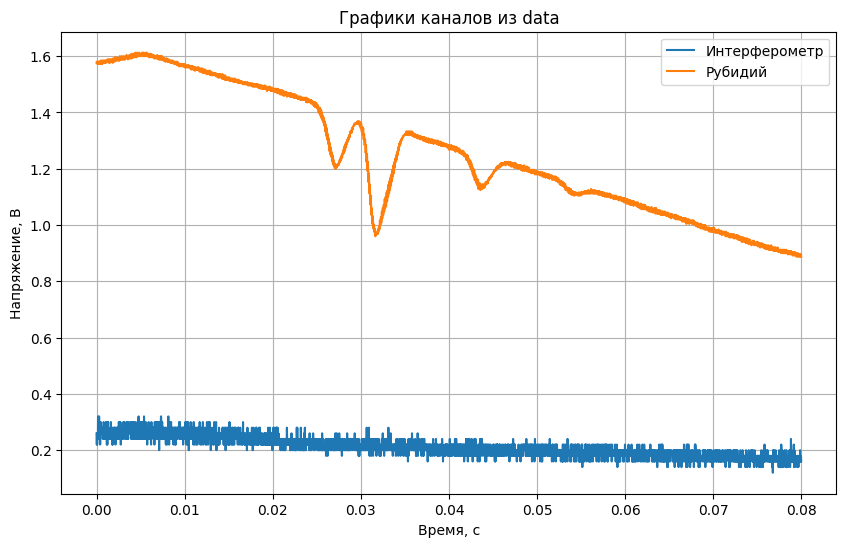

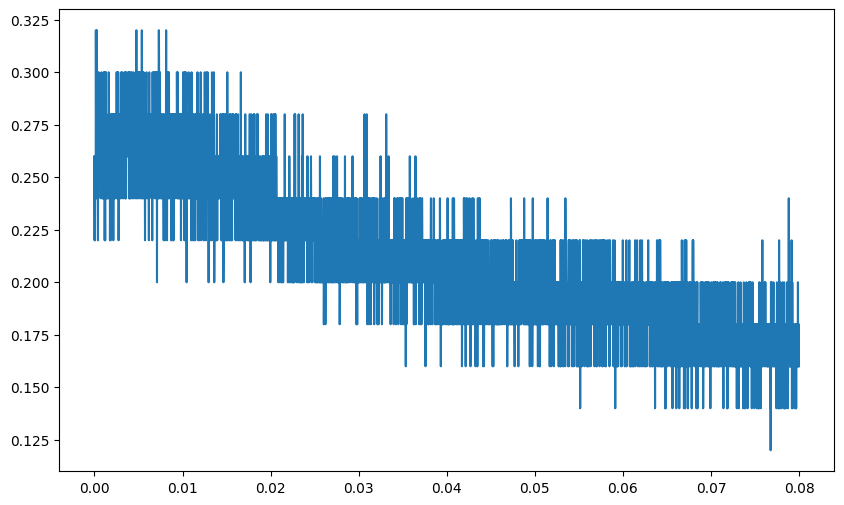

,"Time, s",V_1,V_2,V_3,V_4
0,0.00000,0.26,1.576,4.32,-0.44
1,0.00002,0.22,1.580,4.48,-0.44
2,0.00004,0.26,1.576,4.40,-0.44
3,0.00006,0.22,1.576,4.40,-0.44
4,0.00008,0.24,1.572,4.48,-0.44
...,...,...,...,...,...
3995,0.07990,0.16,0.888,-4.56,-0.60
3996,0.07992,0.16,0.896,-4.56,-0.56
3997,0.07994,0.18,0.896,-4.56,-0.60
3998,0.07996,0.18,0.896,-4.56,-0.56


In [ ]:
data_scan = parse_data_file("41_ma_with_green_mod_line.txt")
plt.figure(figsize=(10, 6))
plt.plot(data_scan["Time, s"], data_scan["V_1"], label="Интерферометр")
plt.plot(data_scan["Time, s"], data_scan["V_2"], label="Рубидий")
# plt.plot(data["Time, s"], data["V_3"], label="Треугольник")
if "V_4" in data.columns:
    plt.plot(data_scan["Time, s"], data_scan["V_4"], label="Зеленая модуляция")
plt.xlabel("Время, с")
plt.ylabel("Напряжение, В")
plt.legend()
plt.grid(True)
plt.title("Графики каналов из data")
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(data_scan["Time, s"], data_scan["V_1"], label="Интерферометр")
plt.show()

data_scan

74.9481145 MHz
423 
 [0.6 0.8 1.8 1.4 0.6]


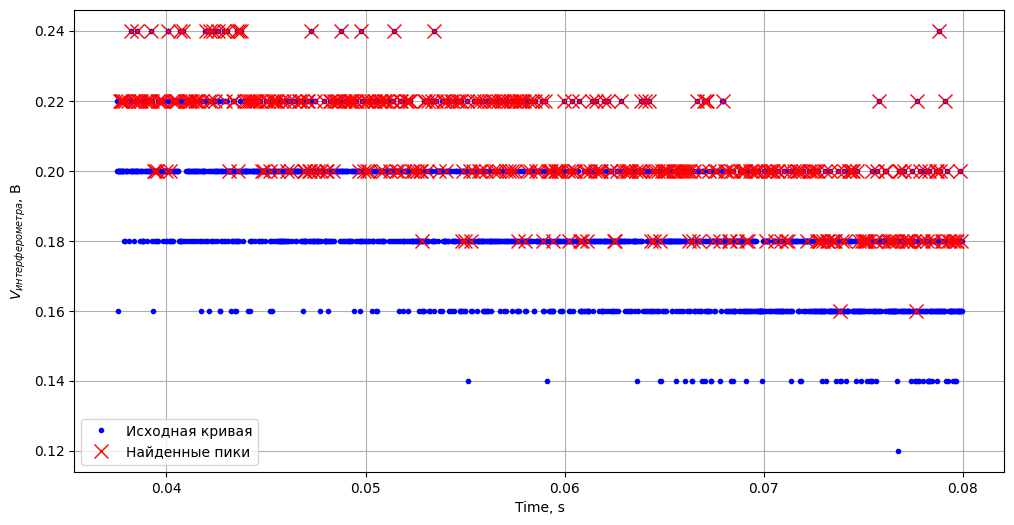

In [ ]:
c = 299792458
a = 1
dnu = c/(4*a)
print(dnu*1E-6, 'MHz') # частоты между пиками интерферометра

# Допустим, у нас есть массив y с значениями кривой
cut_data_wide_scan = data_scan[(data["Time, s"] >= 0.015) & (data["Time, s"] <= 0.065)]
cut_data_scan = data_scan[(data["Time, s"] >= 0.02) & (data["Time, s"] <= 0.06)]
x=cut_data_wide_scan["Time, s"]
y=cut_data_wide_scan["V_1"]
# Находим пики (локальные максимумы)
peaks, _ = sp.signal.find_peaks(np.array(y),   
    distance=3,          # минимум 50 точек между пиками
    prominence=0.01,       # минимальная "выдающаяся" высота
    width=1 )

# Визуализируем результат
plt.figure(figsize=(12, 6))
plt.plot(x, y, "b.", label='Исходная кривая')
plt.plot(np.array(x)[peaks], np.array(y)[peaks], "rx", markersize=10, label='Найденные пики')
peaksx = np.array(x)[peaks]
distances = peaksx*0
for i in range(len(peaksx)-1):
    distances[i] = peaksx[i+1]-peaksx[i]
print(len(distances),"\n",distances[10:15]*10000)
plt.legend()
plt.xlabel("Time, s")
plt.ylabel("$V_{интерферометра}$, В")
plt.grid(True)
plt.show()

def delta_nu(t):
    i = len(peaksx[peaksx<t])-1
    if i < 0 or i >= len(peaksx) - 1:
        raise ValueError("t вне диапазона пиков интерферометра")
    return dnu*(i + (t-peaksx[i])/(peaksx[i+1]-peaksx[i])) 

#cut_data_scan["nu"] = cut_data_scan["Time, s"].apply(delta_nu)



Набор 1:


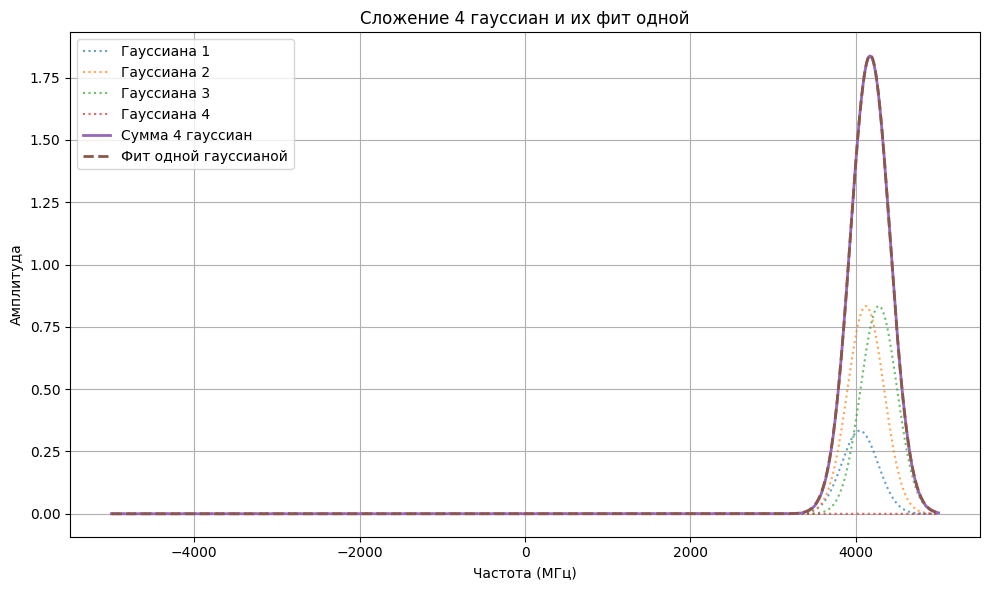

  Параметры фита: A = 1.8395, mu = 4172.6339, sigma = -238.4306

Набор 2:


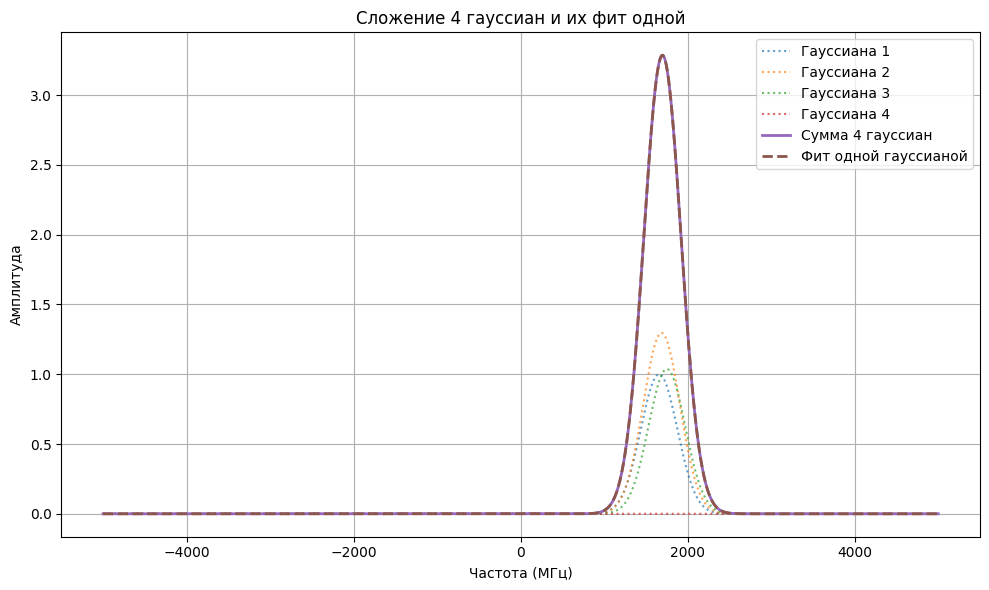

  Параметры фита: A = 3.2858, mu = 1697.7704, sigma = -222.1774

Набор 3:


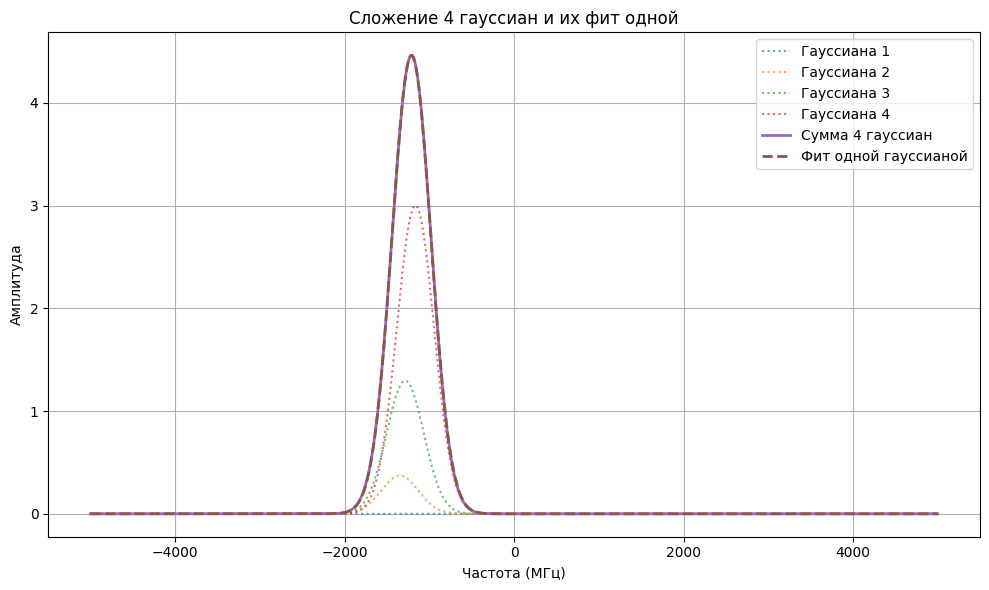

  Параметры фита: A = 4.4622, mu = -1211.5939, sigma = 229.0904

Набор 4:


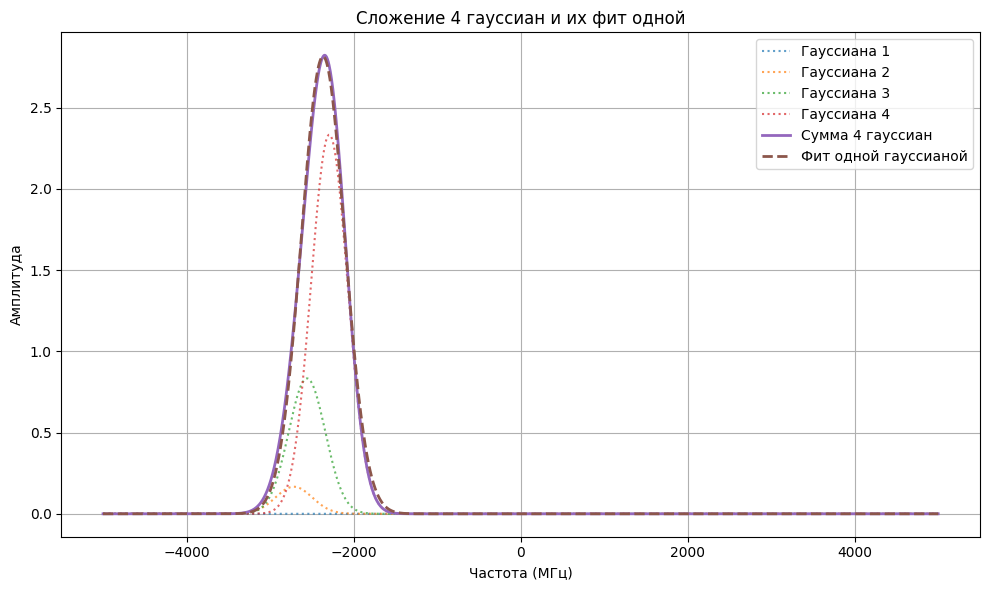

  Параметры фита: A = 2.8152, mu = -2365.8271, sigma = -259.3186



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Гауссиана
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2))

# Функция, которую просил пользователь
def fit_sum_of_gaussians(
    params_list,                # список из 4 троек параметров: [(A1, mu1, sigma1), ..., (A4, mu4, sigma4)]
    initial_guess_fit,          # начальные параметры фита: (A, mu, sigma)
    x_range=(-5000, 5000),      # диапазон x
    num_points=2000             # количество точек на оси x
):
    x = np.linspace(*x_range, num_points)

    # Считаем сумму и отдельные кривые
    y = np.zeros_like(x)
    individual_curves = []
    for A, mu, sigma in params_list:
        g = gaussian(x, A, mu, sigma)
        y += g
        individual_curves.append(g)

    # Фит одной гауссианой
    def single_gaussian(x, A, mu, sigma):
        return gaussian(x, A, mu, sigma)

    params_fit, _ = curve_fit(single_gaussian, x, y, p0=initial_guess_fit)
    y_fit = single_gaussian(x, *params_fit)

    # График
    plt.figure(figsize=(10, 6))
    for i, g in enumerate(individual_curves):
        plt.plot(x, g, linestyle=':', label=f'Гауссиана {i+1}', alpha=0.7)

    plt.plot(x, y, label='Сумма 4 гауссиан', linewidth=2)
    plt.plot(x, y_fit, '--', label='Фит одной гауссианой', linewidth=2)

    plt.title('Сложение 4 гауссиан и их фит одной')
    plt.xlabel('Частота (МГц)')
    plt.ylabel('Амплитуда')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return params_fit  # (A, mu, sigma)

# Гауссианы из таблицы: [(A, mu, sigma), ...]
sigma = 219

# Набор 3: 85Rb, Fg=3
set3 = [
    (0, -1378.06875, sigma),
    (10/27, -1348.75475, sigma),
    (35/27, -1285.37375, sigma),
    (81/27, -1164.63375, sigma),
]

# Набор 2: 85Rb, Fg=2
set2 = [
    (1, 1657.66125, sigma),
    (35/27, 1686.97525, sigma),
    (28/27, 1750.35625, sigma),
    (0, 1871.09625, sigma),
]

# Набор 4: 87Rb, Fg=2
set4 = [
    (0, -2787.4225, sigma),
    (1/6, -2715.0995, sigma),
    (5/6, -2557.9295, sigma),
    (14/6, -2290.8745, sigma),
]

# Набор 1: 87Rb, Fg=1
set1 = [
    (2/6, 4047.2575, sigma),
    (5/6, 4119.5825, sigma),
    (5/6, 4276.7525, sigma),
    (0, 4543.8075, sigma),
]

# Начальное приближение для фита (A, mu, sigma)
initial_guess = [4, 0, sigma ]

# Запускаем для всех 4 наборов
results_weight_fit = []
for i, dataset in enumerate([set1, set2, set3, set4], start=1):
    print(f"Набор {i}:")
    initial_guess[2] = dataset[1][1]
    fit_params = fit_sum_of_gaussians(dataset, initial_guess)
    print("  Параметры фита: A = {:.4f}, mu = {:.4f}, sigma = {:.4f}\n".format(*fit_params))
    results_weight_fit.append(fit_params)


In [44]:
As_theor = np.array([x[0] for x in results_weight_fit])
As_theor = As_theor * np.array([3/8,5/12,7/12,5/8])
As_experiment = np.array([x[0] for x in gauss_params_tuples])
print(As_experiment)
print(As_theor)
As_exp_theor = (As_experiment/As_theor)
print(As_exp_theor)
print(As_exp_theor[1]/As_exp_theor[0], As_exp_theor[2]/As_exp_theor[3])

[0.05441738 0.15614144 0.36828384 0.18117279]
[0.68980044 1.36907324 2.60294652 1.75952608]
[0.07888859 0.114049   0.14148729 0.10296681]
1.4456970395143403 1.374105751903379


In [29]:
dV = 6.8e9
k = 1.380649e-23
h=6.63e-34
print(np.exp(-dV*h/k/300))


0.9989121185633743
